# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is montly_champagne_sales

## 02 - Load Data
Let's start by loading the time series of the challenge

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import scipy
import pandas as pd

In [2]:
df = pd.read_csv('monthly_champagne_sales.csv', parse_dates = ['Month'], index_col = ['Month'])
 
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


👉 Convert dataframe with datetime objects as index to make it look like this
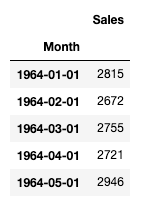

## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

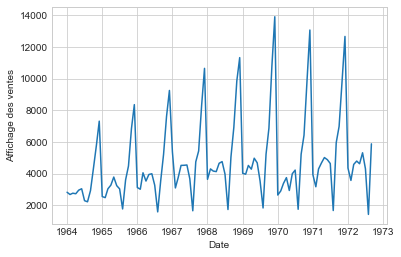

In [3]:
plt.xlabel('Date')
plt.ylabel('Affichage des ventes')
plt.plot(df)

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

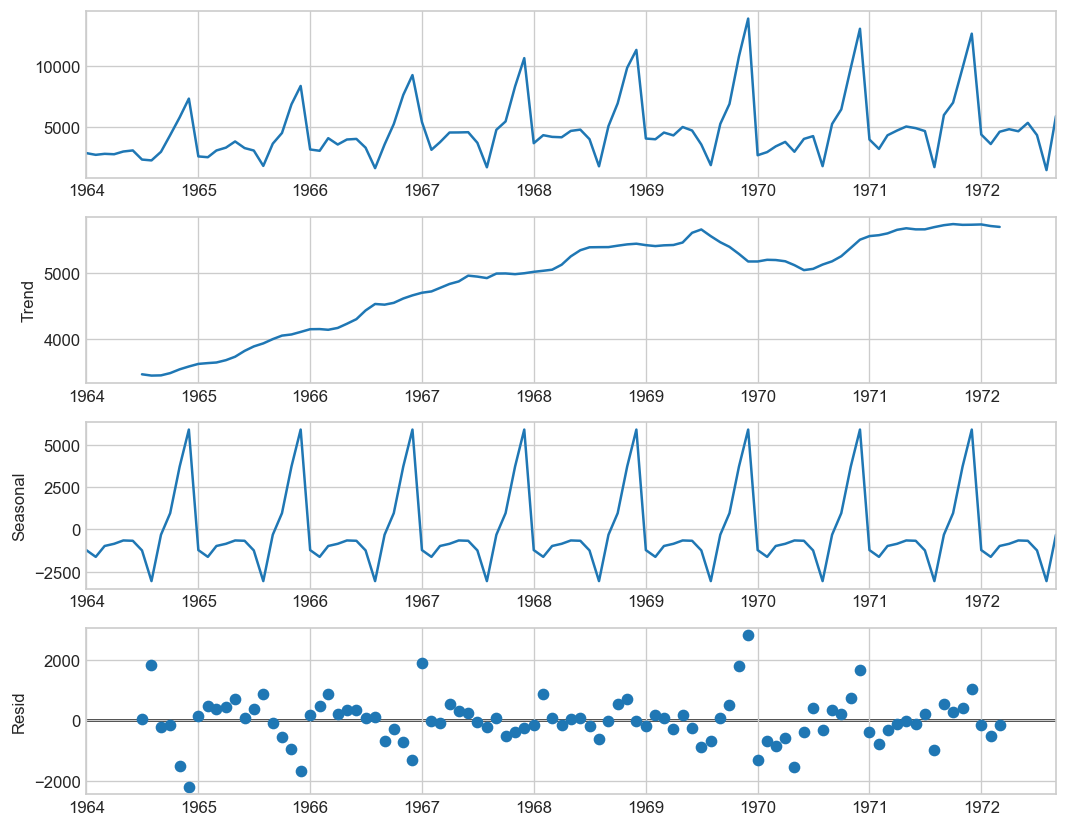

In [4]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df)
result.plot();
#result.resid.plot();

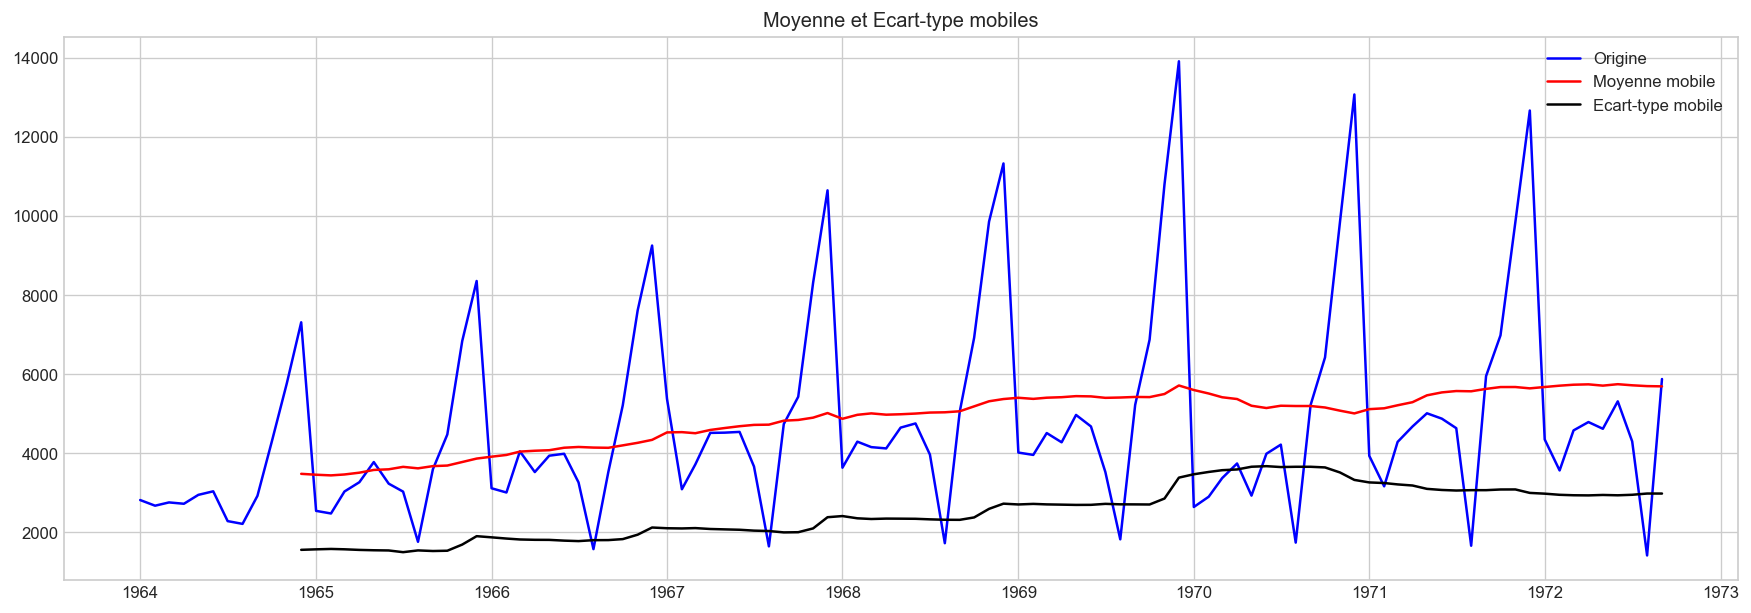

In [5]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.figure(figsize=(18,6))
plt.plot(df, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

👉 De-seasonalize this time serie using the decomposition of your choice

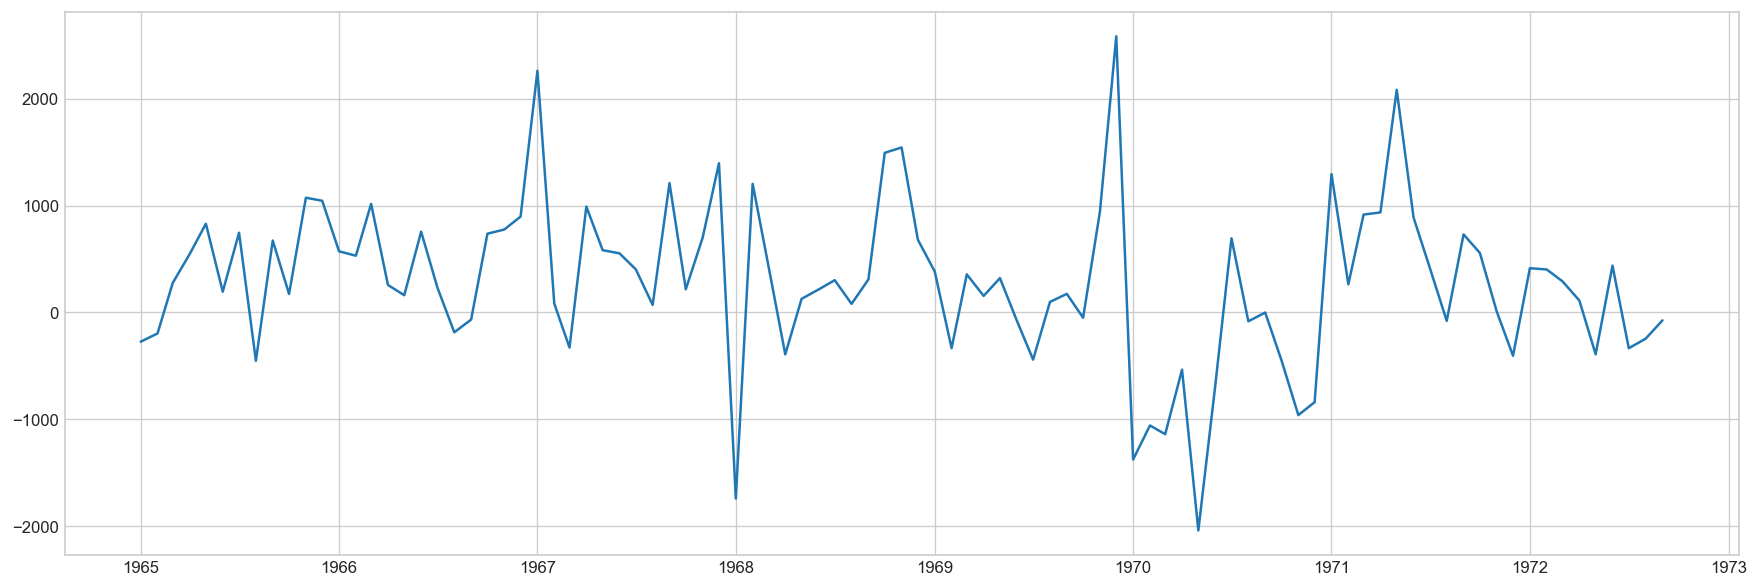

In [6]:
y_diff= df.diff(12).dropna()
plt.figure(figsize=(18,6))
plt.plot(y_diff);

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_diff)
result[1] 
# print('Statistiques ADF : {}'.format(result[0]))
# print('p-value : {}'.format(result[1]))
# print('Valeurs Critiques :')
# for key, value in result[4].items():
#     print('\t{}: {}'.format(key, value))

2.060579696813685e-11

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [8]:
df_train = df[:'1969-12-1']
df_test = df['1970-01-01':]

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_train)
result
# print('Statistiques ADF : {}'.format(result[0]))
# print('p-value : {}'.format(result[1]))
# print('Valeurs Critiques :')
# for key, value in result[4].items():
#     print('\t{}: {}'.format(key, value))

(-0.9374619092287443,
 0.7753855460224324,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 937.6328591507947)

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

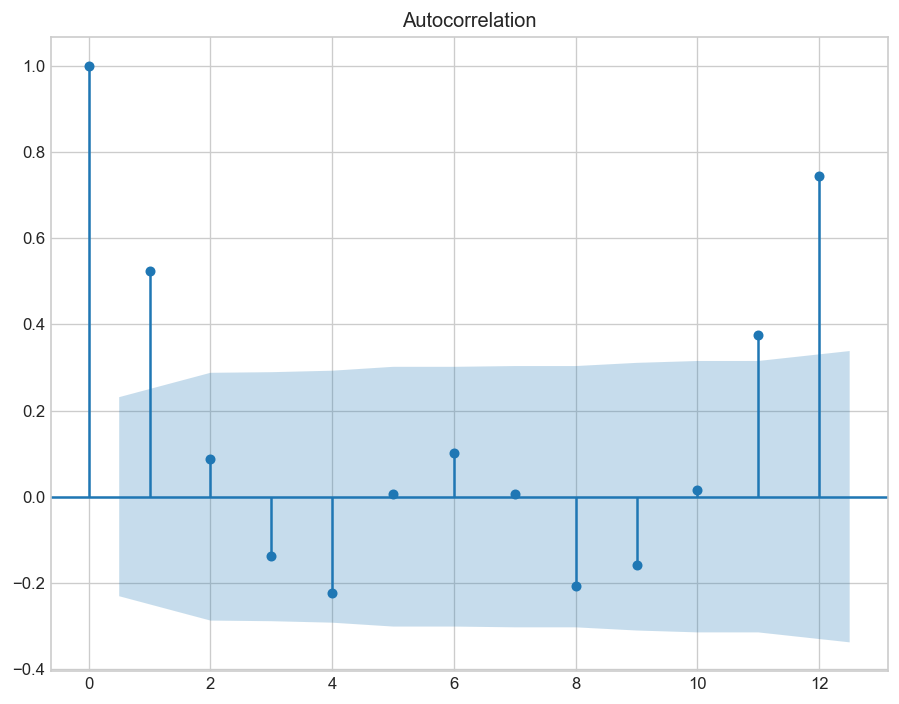

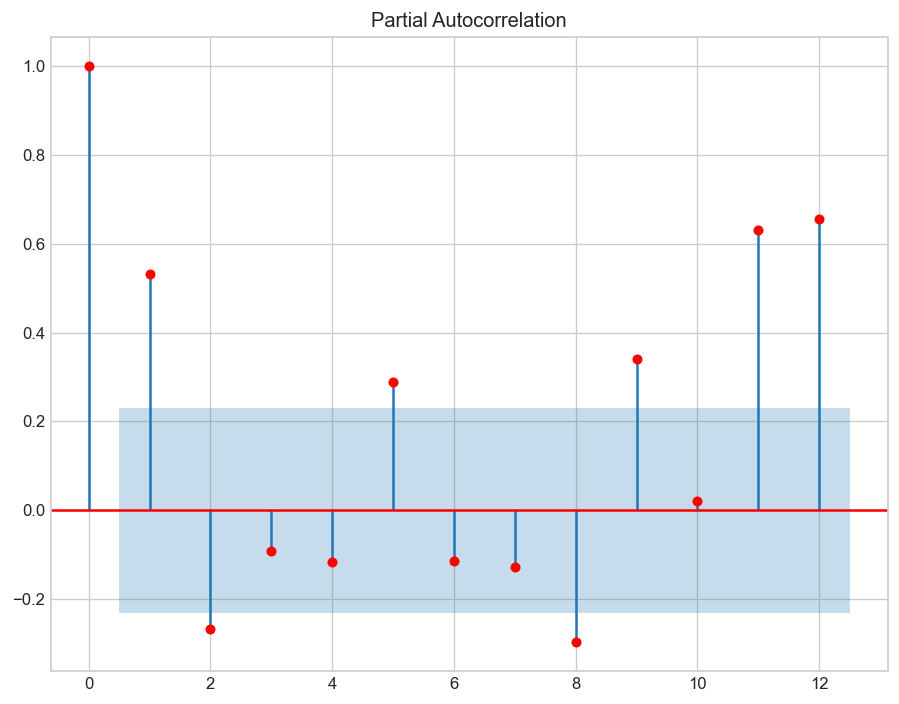

In [10]:
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_train, lags=12) 
plot_pacf(df_train, lags=12, color='r', alpha=0.05)
plt.show();

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy
mod = sm.tsa.arima.ARIMA(df_train, order=(1,0,1))
res = mod.fit()

print(res.summary())

C:\Users\TURBULANCE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\TURBULANCE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\TURBULANCE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -646.091
Date:                Sat, 12 Feb 2022   AIC                           1300.183
Time:                        21:45:29   BIC                           1309.290
Sample:                    01-01-1964   HQIC                          1303.808
                         - 12-01-1969                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4636.3335    503.521      9.208      0.000    3649.450    5623.217
ar.L1          0.0309      0.134      0.231      0.817      -0.231       0.293
ma.L1          0.8155      0.103      7.891      0.0

C:\Users\TURBULANCE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\TURBULANCE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\TURBULANCE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


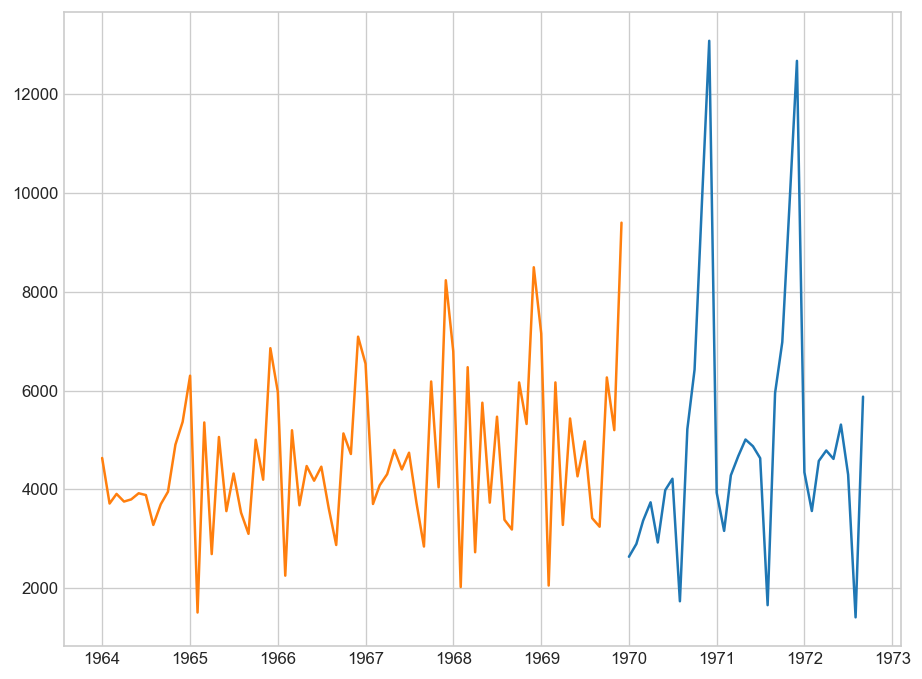

In [12]:
mod = sm.tsa.arima.ARIMA(df_train, order=(1, 0, 1))
res = mod.fit()
pred= res.predict()
plt.plot(df_test)
plt.plot(pred)

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

In [13]:
# plot_acf(y_diff, lags=12) 
# plot_pacf(y_diff, lags=12, color='r', alpha=0.05)
# plt.show();

2.647350636254994e-09


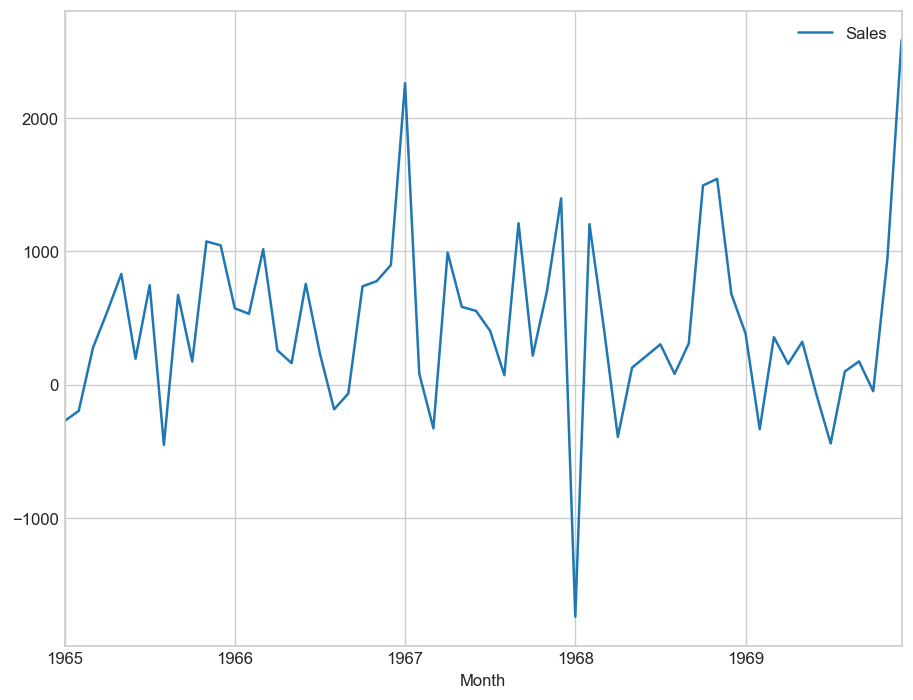

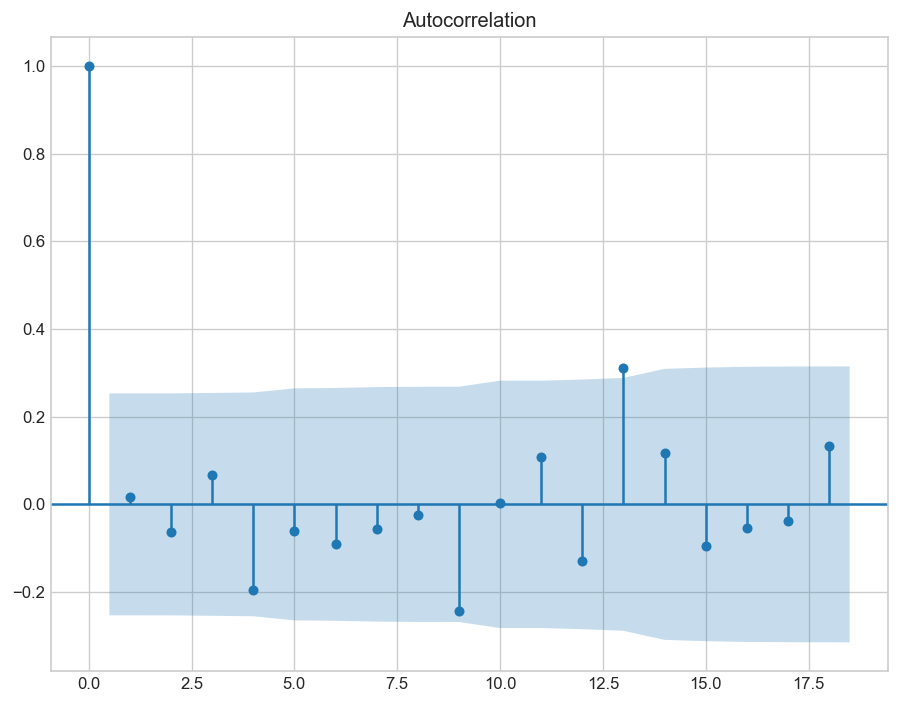

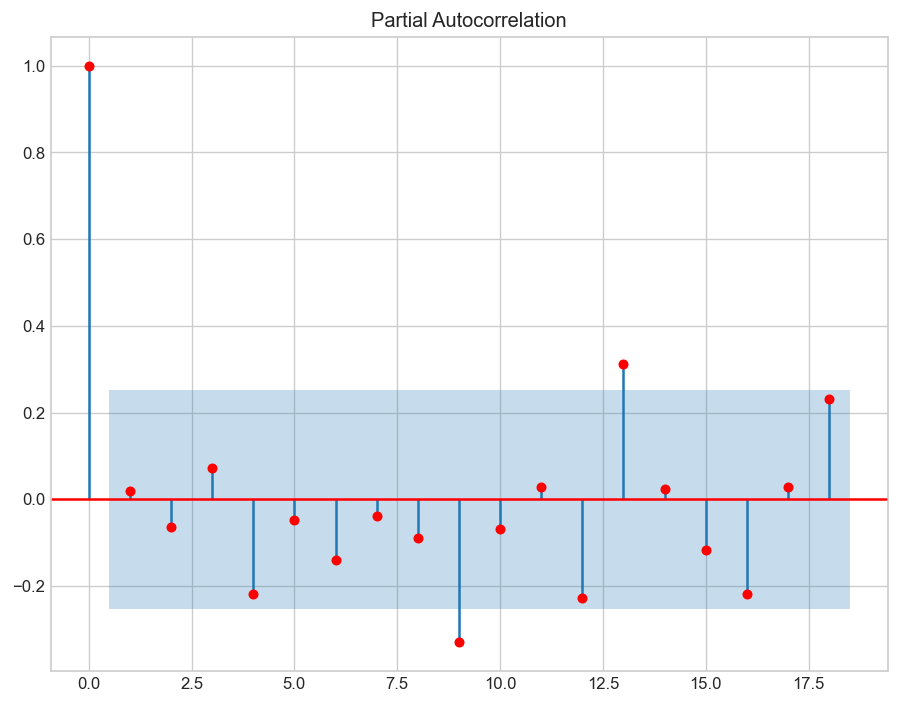

In [14]:
df_train_diff = df_train.diff(12).dropna()
print(adfuller(df_train_diff)[1])
df_train_diff.plot()
plot_acf(df_train_diff);
plot_pacf(df_train_diff, color='r');
plt.show();

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

0.000518392375254077


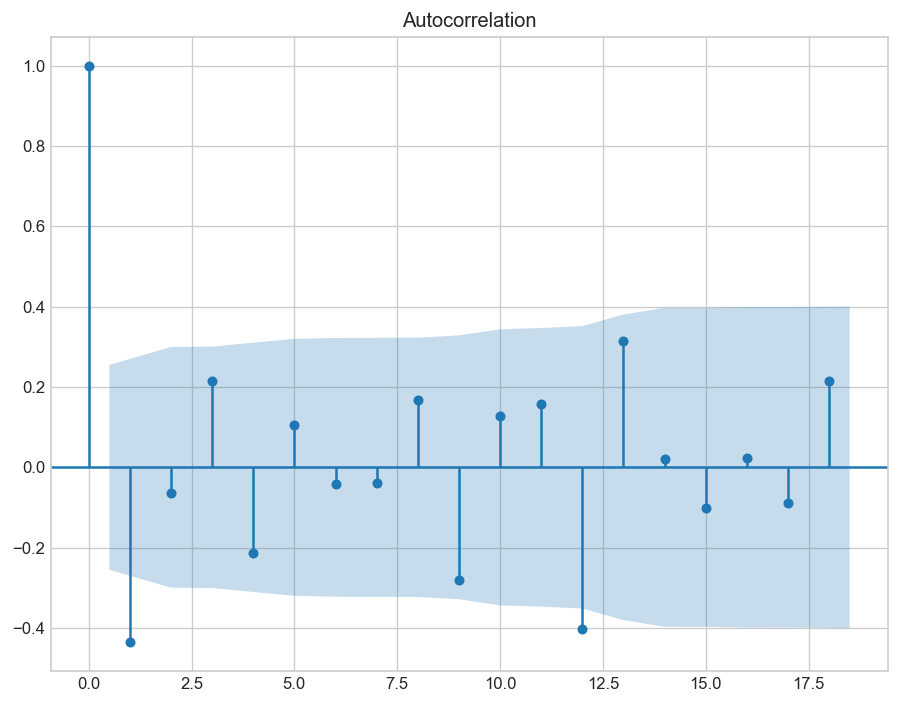

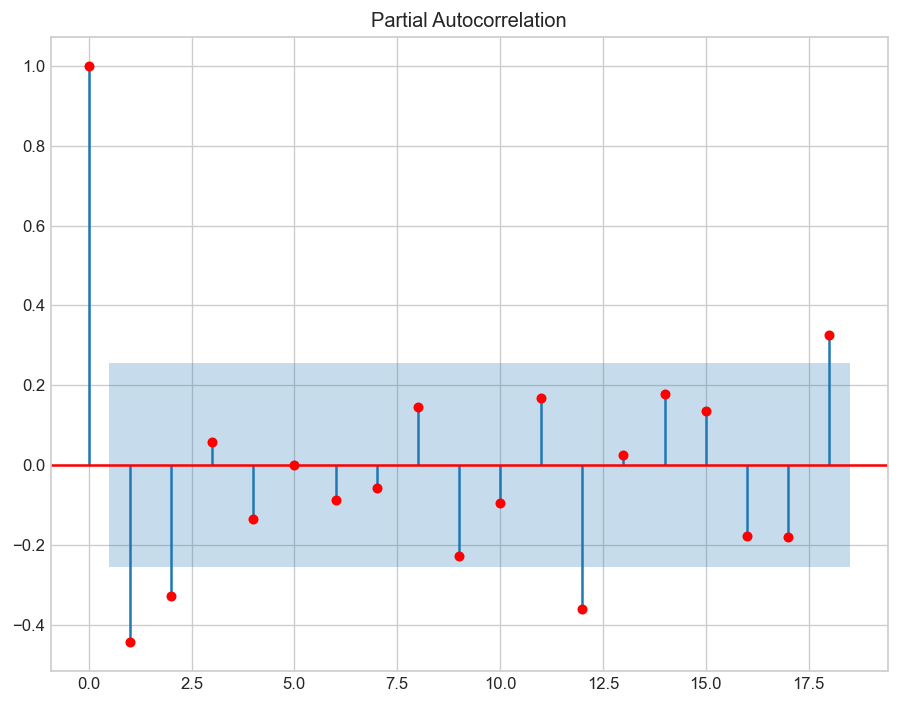

In [15]:
test_diff = df_train_diff.diff().dropna()
print(adfuller(test_diff)[1])
plot_acf(test_diff);
plot_pacf(test_diff, color='r');
plt.show();

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

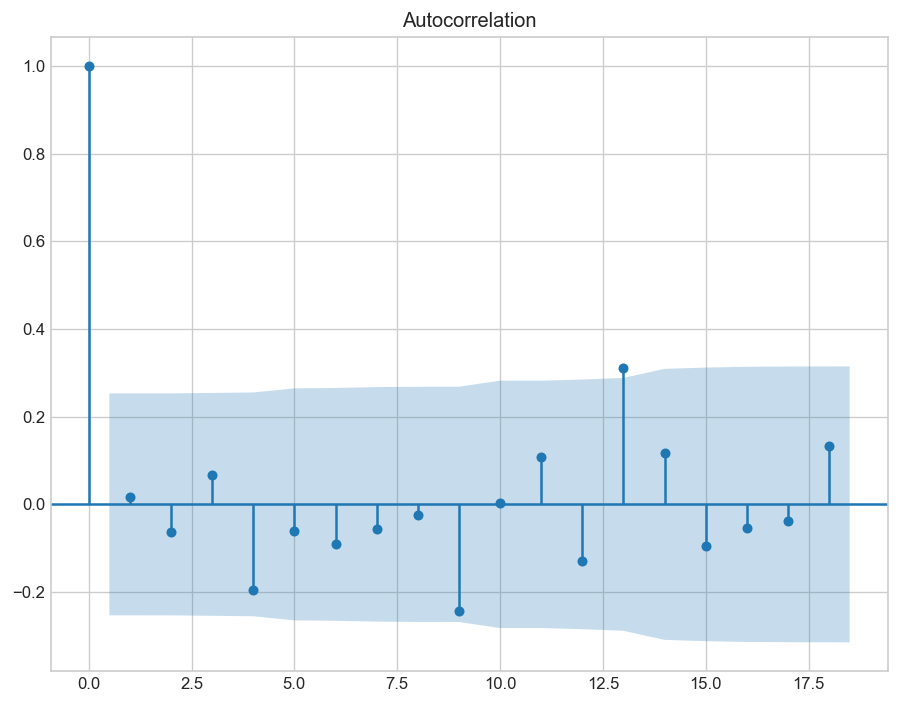

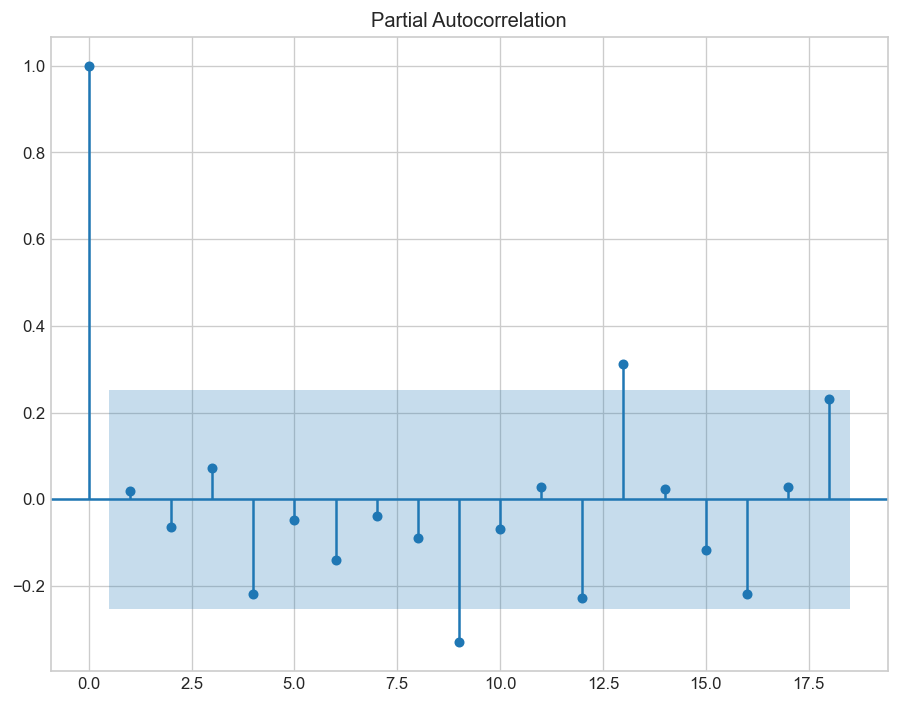

In [16]:
plot_acf(df_train_diff);
plot_pacf(df_train_diff);

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [17]:
import pmdarima

model = pmdarima.auto_arima(df_train, 
                      start_p=0, start_q=0,
                      max_p=3, max_q=3, # maximum p and q
                      start_P=0, start_Q=0,
                      max_P=1, max_Q=1, # maximum P and Q
                      m=12,
                      D = 1,
                      d = None,
                      trace=True,
                      njobs=-1)
print(model.summary())                     

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=1.89 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.06 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.35 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=1.57 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=2.13 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.21 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.29 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.52 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 7.703 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood 

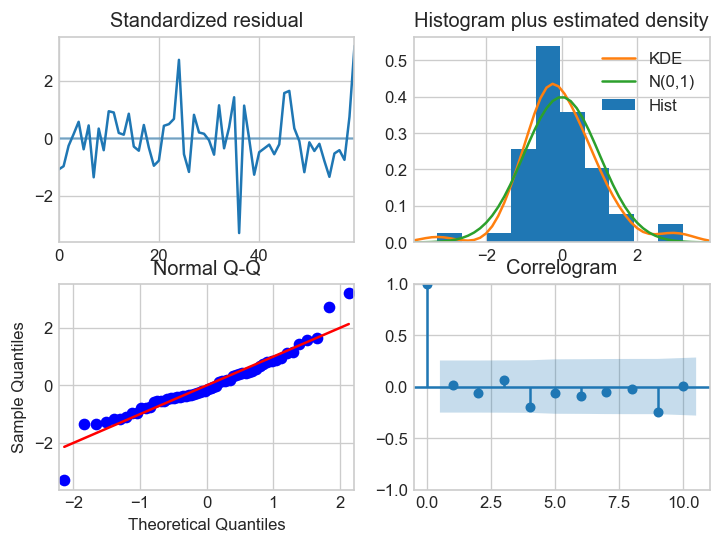

In [18]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [19]:
y_pred, conf_int = model.predict(len(df_test), return_conf_int=True)
central = pd.Series(y_pred, index = df_test.index)
lower = pd.Series(conf_int[:, 0], index = df_test.index)
upper = pd.Series(conf_int[:, 1], index = df_test.index)

👇 Run the cell below to plot your predictions against reality

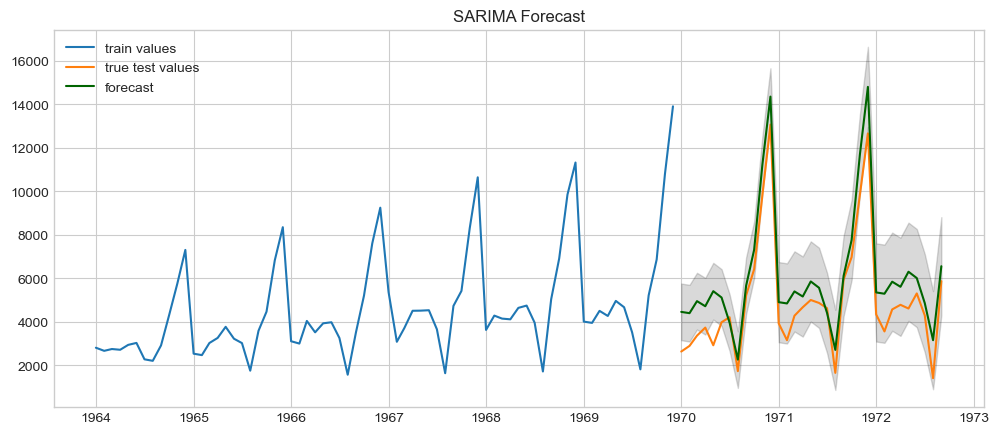

In [20]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!